# Using cleverhans within SecML

In this tutorial we will show how to craft evasion attacks against machine 
learning models in SecML through the `Cleverhans` interface.

### Training the model

The first part is the same as the other notebooks ([Training models](01-Training.ipynb)). We load here a 2D dataset,
so that we can easily plot the attack initial point and path.

In [1]:
random_state = 999

n_features = 2  # Number of features
n_samples = 1100  # Number of samples
centers = [[-2, 0], [2, -2], [2, 2]]  # Centers of the clusters
cluster_std = 0.75  # Standard deviation of the clusters
n_classes = len(centers)

from secml.data.loader import CDLRandomBlobs

dataset = CDLRandomBlobs(n_features=n_features,
                         centers=centers,
                         cluster_std=cluster_std,
                         n_samples=n_samples,
                         random_state=random_state).load()

n_tr = 1000  # Number of training set samples
n_ts = 100  # Number of test set samples

# Split in training and test
from secml.data.splitter import CTrainTestSplit

splitter = CTrainTestSplit(
    train_size=n_tr, test_size=n_ts, random_state=random_state)
tr, ts = splitter.split(dataset)

# Normalize the data
from secml.ml.features import CNormalizerMinMax

nmz = CNormalizerMinMax()
tr.X = nmz.fit_transform(tr.X)
ts.X = nmz.transform(ts.X)

# Metric to use for training and performance evaluation
from secml.ml.peval.metrics import CMetricAccuracy

metric = CMetricAccuracy()

# Creation of the multiclass classifier
import torch
from torch import nn

class Net(nn.Module):
    """
    Model with input size (-1, 5) for blobs dataset
    with 5 features
    """
    def __init__(self, n_features, n_classes):
        """Example network."""
        super(Net, self).__init__()
        self.fc1 = nn.Linear(n_features, 50)
        self.fc2 = nn.Linear(50, n_classes)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Random seed for PyTorch
torch.manual_seed(random_state)

# torch model creation
net = Net(n_features=n_features, n_classes=n_classes)

from torch import optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(),
                      lr=0.001, momentum=0.9)

# wrap torch model in CClassifierPyTorch class
from secml.ml.classifiers import CClassifierPyTorch
clf = CClassifierPyTorch(model=net,
                         loss=criterion,
                         optimizer=optimizer,
                         input_shape=(n_features,),
                         epochs=5,
                         random_state=random_state)

# We can now fit the classifier
clf.fit(tr)

# Compute predictions on a test set
y_pred = clf.predict(ts.X)

# Evaluate the accuracy of the classifier
acc = metric.performance_score(y_true=ts.Y, y_pred=y_pred)

print("Accuracy on test set: {:.2%}".format(acc))

Accuracy on test set: 100.00%


## Attack initialization

Now that we have the model we can prepare the attacks. We will test several 
attack algorithm from
 [cleverhans](https://github.com/tensorflow/cleverhans) library.


### Initial point
We can specify a starting point for the attacks, we select a point from the class 1, 
which is in the lower right-corner of the 2D plane. As always, we can define a box for 
the attack in order to comply with the feature range (`[0, 1]`) and a maximum distance, 
as well as the target class (as always, specifying `y_target=None` will produce an 
untargeted attack).

In [2]:
from secml.array import CArray

# x0, y0 = ts[5, :].X, ts[5, :].Y  # Initial sample
x0, y0 = CArray([0.7, 0.4]), CArray([1])
lb, ub = 0, 1
dmax = 0.4
y_target = 2

### Attack parameters

We can finally specify the parameters for the attacks. We can compare the paths of 
several attacks, for which the parameters can be found in 
[cleverhans docs](https://cleverhans.readthedocs.io/en/latest/).

We are going to use the following attacks:

>* [FGM](http://arxiv.org/abs/1412.6572) 
  >Goodfellow IJ, Shlens J, Szegedy C. Explaining and Harnessing 
  >Adversarial Examples. arXiv:14126572 [cs, stat] [Internet]. 2014
* [PGD](http://arxiv.org/abs/1607.02533) 
  >Kurakin A, Goodfellow I, Bengio S. Adversarial examples in the 
  >physical world. arXiv:160702533 [cs, stat] [Internet]. 2017
* [MIM](https://ieeexplore.ieee.org/document/8579055/) 
  >Dong Y, Liao F, Pang T, Su H, Zhu J, Hu X, et al. Boosting 
  >Adversarial Attacks with Momentum. In: 2018 IEEE/CVF Conference 
  >on Computer Vision and Pattern Recognition [Internet]. Salt Lake 
  >City, UT: IEEE; 2018 
* [CW](http://arxiv.org/abs/1608.04644) 
  >Carlini N, Wagner D. Towards Evaluating the Robustness of 
  >Neural Networks. arXiv:160804644 [cs] [Internet]. 2016


In [3]:
from cleverhans.attacks import CarliniWagnerL2, ProjectedGradientDescent, MomentumIterativeMethod,FastGradientMethod
from collections import namedtuple
Attack = namedtuple('Attack', 'attack_cls short_name attack_params')

max_iter = 200

attacks = [
    Attack(FastGradientMethod, 'FGM', {'eps': dmax,
                                       'clip_max': ub,
                                       'clip_min': lb,
                                       'ord': 2}),
    Attack(ProjectedGradientDescent, 'PGD', {'eps': dmax,
                                             'eps_iter': 0.03,
                                             'nb_iter': max_iter,
                                             'clip_max': ub,
                                             'clip_min': lb,
                                             'ord': 2,
                                             'rand_init': False}),
    Attack(MomentumIterativeMethod, 'MIM', {'eps': dmax,
                                            'eps_iter': 0.03,
                                            'nb_iter': max_iter,
                                            'clip_max': ub,
                                            'clip_min': lb,
                                            'ord': 2,
                                            'decay_factor': 1}),
    Attack(CarliniWagnerL2, 'CW2', {'binary_search_steps': 1,
                                    'initial_const': 0.2,
                                    'confidence': 10,
                                    'abort_early': True,
                                    'clip_min': lb,
                                    'clip_max': ub,
                                    'max_iterations': max_iter,
                                    'learning_rate': 0.1})]

### Running the attacks

We can now run the attacks by passing them to the 
`CAttackEvasionCleverhans` class, which handles the 
attack optimization and provides useful output as 
the attack path and objective function. We can plot these 
information with the help of the `CFigure` module and its 
powerful APIs `plot_function` and `plot_path`.

Attack FGM started...
Attack finished!
Original x0 label:  1
Adversarial example label (FastGradientMethod):  2
Number of classifier function evaluations: 3
Number of classifier gradient evaluations: 3
Attack PGD started...
Attack finished!
Original x0 label:  1
Adversarial example label (ProjectedGradientDescent):  2
Number of classifier function evaluations: 600
Number of classifier gradient evaluations: 600
Attack MIM started...
Attack finished!
Original x0 label:  1
Adversarial example label (MomentumIterativeMethod):  2
Number of classifier function evaluations: 600
Number of classifier gradient evaluations: 600
Attack CW2 started...
Attack finished!
Original x0 label:  1
Adversarial example label (CarliniWagnerL2):  2
Number of classifier function evaluations: 303
Number of classifier gradient evaluations: 303


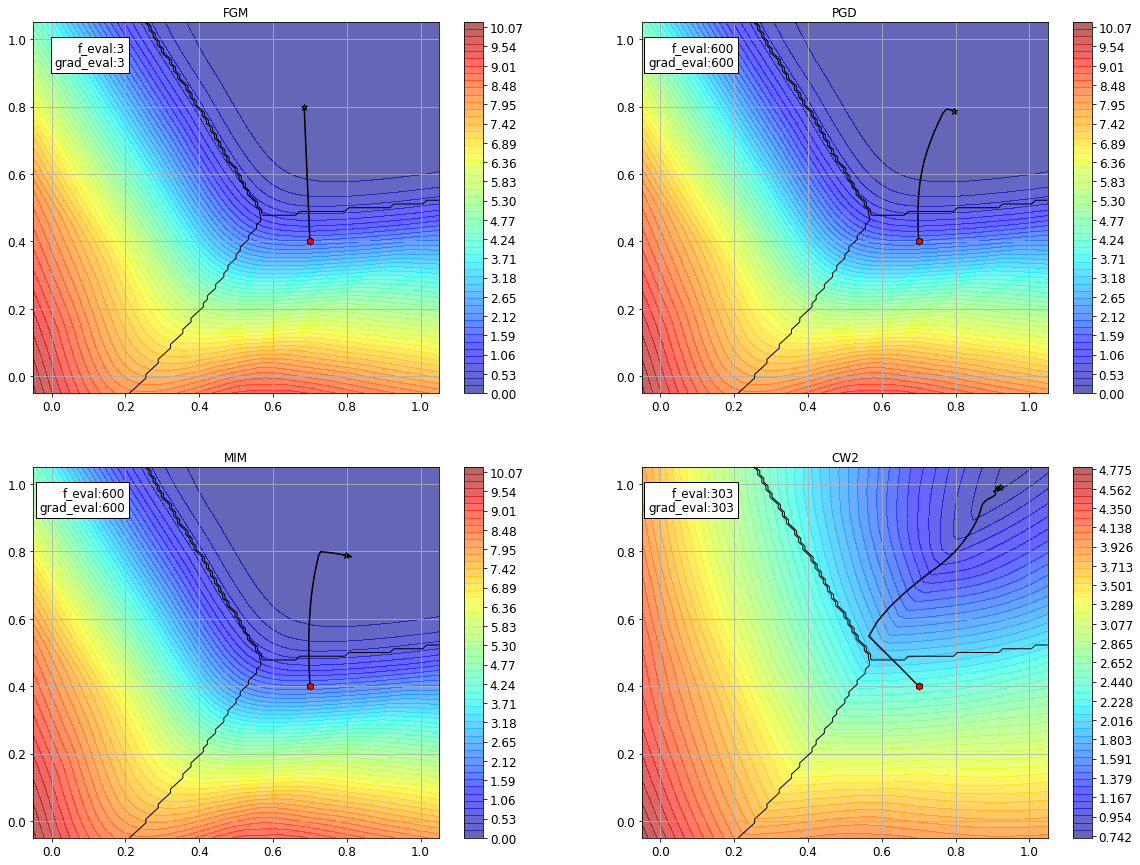

In [4]:
from secml.figure import CFigure
# Only required for visualization in notebooks
%matplotlib inline

from secml.adv.attacks import CAttackEvasionCleverhans

fig = CFigure(width=20, height=15)

for i, attack in enumerate(attacks):
    fig.subplot(2, 2, i + 1)
    
    fig.sp.plot_decision_regions(clf,
                                 plot_background=False,
                                 n_grid_points=100)
    
    cleverhans_attack = CAttackEvasionCleverhans(
        classifier=clf,
        surrogate_classifier=clf,
        surrogate_data=tr,
        y_target=y_target,
        n_classes=clf.n_classes,
        n_feats=clf.n_features, 
        clvh_attack_class=attack.attack_cls,
        **attack.attack_params)

    # Run the evasion attack on x0
    print("Attack {:} started...".format(attack.short_name))
    y_pred_CH, _, adv_ds_CH, _ = cleverhans_attack.run(x0, y0)
    print("Attack finished!")

    fig.sp.plot_fun(cleverhans_attack.objective_function,
                    multipoint=True, plot_levels=False,
                    n_grid_points=50, alpha=0.6)

    print("Original x0 label: ", y0.item())
    print("Adversarial example label ({:}): "
          "".format(attack.attack_cls.__name__), y_pred_CH.item())

    print("Number of classifier function evaluations: {:}"
          "".format(cleverhans_attack.f_eval))
    print("Number of classifier gradient evaluations: {:}"
          "".format(cleverhans_attack.grad_eval))

    fig.sp.plot_path(cleverhans_attack.x_seq)
    fig.sp.title(attack.short_name)
    fig.sp.text(0.2, 0.92, "f_eval:{}\ngrad_eval:{}"
                           "".format(cleverhans_attack.f_eval,
                                     cleverhans_attack.grad_eval),
                bbox=dict(facecolor='white'), horizontalalignment='right')
fig.show()